In [2]:
import matplotlib.pyplot as plt
import numba
import numpy as np

In [113]:
# Lattice vectors
L = 0.01
a = np.sqrt(3)*L


lat_vec = a * np.array([
    [-1/2, np.sqrt(3)/2],
    [1/2, np.sqrt(3)/2]
])
a1, a2= lat_vec

# Sublattice offsets
basis = a * np.array([
    [0, 0],
    [1/4, np.sqrt(3)/4],
    [0, np.sqrt(3)/2]
])


# Reciprocal lattice vectors
rec_vec = 2*np.pi*np.linalg.inv(lat_vec).T
b1, b2= rec_vec


# High-symmetry points
G = np.array([0., 0.])
K = np.array([(b1 + 2*b2)/3, (-b1 + b2)/3, (b2 + 2*b1)/3, -(b1 + 2*b2)/3, -(-b1 + b2)/3, -(b2 + 2*b1)/3])
M = np.array([(b1 + b2)/2, b2/2, b1/2, -(b1 + b2)/2, -b2/2, -b1/2])
print(K.shape)

(6, 2)


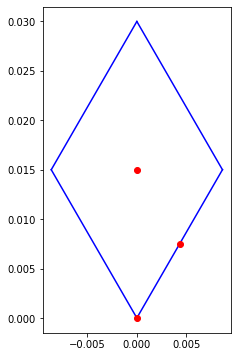

In [114]:
'''
Blue is the unit cell and the red dots are the cavities within a unit cell
'''
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
ax.plot([0,a1[0]], [0,a1[1]], 'b-')
ax.plot([0,a2[0]], [0,a2[1]], 'b-')
ax.plot([0, a1[0]], [np.sqrt(3)*a,a1[1]],'b-')
ax.plot([0, a2[0]], [np.sqrt(3)*a,a2[1]],'b-')
ax.set_aspect("equal")
#plt.axis([0, 5, -2.5, 2.5])
ax.plot(basis[:,0],basis[:,1], 'ro')



In [115]:
@numba.njit
def make_rmesh(N, offset=G):
    """Make a coordinate mesh grid.

    r[:,n,i,j] = i * a1 + j * a2 + R_n + offset

    Parameters
    ----------
    N1, N2 : int
        Number of sites.
    lat_vec : ndarray
    offset : ndarray
        Offset of vectors.

    Returns
    -------
    rs : ndarray
        Coordinates.
    """
    rs = np.empty((2, 3, N, N)) 
    '''
    (A, B, C, D): 
    A: the number of spatial dimensions. Now we are analyzing a 2D material so we use A=2
    B: the number of sublattices. Now we are studying kagome, which has 3 sublattices, so we use B=3
    C: the number of rows in the grid
    D: the number of columns in the grid
    '''
    f = np.arange(N)
    #f[N//2:] -= N 
    
    '''
    // is the floor division. It divides A by B and round the answer to the integer below
    f[N//2:] means select the items of f from index N//2 to the end
    So f = [0, 1, 2, ..., floor(N/2) - N, ....]
    If we use N=7, we have:
    f = [0, 1, 2, -4, -3, -2, -1]
    
    This is probably due to the way they stored their data. For our way of storing data, we don't need to use
    that line of code to manually switch things around in real space
    '''
    
    for n in range(3):
        for i in range(N):
            for j in range(N):
                rs[:,n,i,j] = f[i]*a1 + f[j]*a2 + basis[n] + offset
    return rs


@numba.njit
def make_kmesh(N, offset=G, tile=1):
    """Make a k-mesh grid on the trapezoidal Brillouin zone.

    k[:,i,j] = i/N1 * b1 + j/N2 * b2 + offset

    Parameters
    ----------
    N1, N2 : int
        Number of k-points.
    offset : ndarray
        Offset of vectors.
    tile : int
        Number of BZ repetitions.

    Returns
    -------
    ks : ndarray
        k vectors.
    """
    b1 = rec_vec[0]
    b2 = rec_vec[1]
    ks = np.empty((2, tile*N, tile*N))
    for i in range(tile*N):
        for j in range(tile*N):
            ks[:,i,j] = i/N * b1 + j/N * b2 + offset
    return ks

In [116]:
V = 1.
delta = 0.01
Nk = 7
nr = np.empty((3, Nk, Nk), dtype=complex)
for i in range(3):
    nr[i] = np.load(f'../../data/FT_debug/preprocessed/1cavity{i+1}.npy')


In [117]:
x, y = make_rmesh(Nk)

/Users/jiatongyang/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


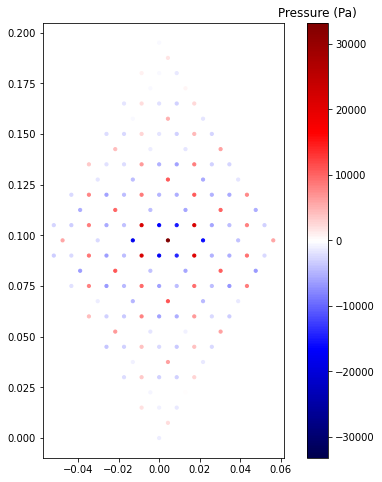

In [118]:
c = nr
vmax = np.abs(c).max()

fig, ax = plt.subplots(figsize=(8,8))
s = ax.scatter(x, y, s=10, c=c, vmin=-vmax, vmax=vmax, cmap='seismic')
#ax.set_xlim(-50, 50)
#ax.set_ylim(-50, 50)
ax.set_aspect(1)
#ax.set_xticks([])
#ax.set_yticks([])
cb = fig.colorbar(s, ax=ax)
cb.ax.set_title('Pressure (Pa)')

plt.savefig(f"../../data/FT_debug/figures/14.174kHz_realSpace.png")

The coordinates and momenta are
$$ r = n_1 a_1 + n_2 a_2 + R_n $$
$$ q = \frac{m_1}{N} b_1 + \frac{m_2}{N} b_2 $$
$$ q \cdot r = \frac{2\pi}{N} (m_1 n_1 + m_2 n_2) + q \cdot R_n $$

The Fourier transform is
$$ A_q = \sum_r a_r e^{-iqr} \\
= \sum_{n, n_1, n_2} a_r \exp\left( -2\pi i(m_1 n_1 + m_2 n_2) - iq \cdot R_n \right) \\
= \sum_n e^{-iq \cdot R_n} \sum_{n_1, n_2} a_r \exp\left( -\frac{2\pi i}{N} (m_1 n_1 + m_2 n_2) \right) $$
I.e. the Fourier transform is the sum of the DFT of each sublattice with a phase offset.

362.75987284684356
(3, 21, 21)


/Users/jiatongyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


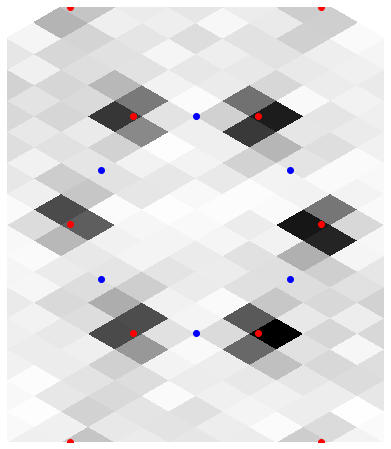

In [121]:
# Tile FT odd order

'''
    When tiling things in odd numbers of copies, I use the fftshift function in order to make sure that the
    origin is always at the center of the whole matrix
'''

tileNum = 3
q = make_kmesh(Nk, -tileNum/2*(b1+b2), tileNum)
#nq = np.tile(np.fft.fft2(nr), (tileNum, tileNum))
nq = np.tile(np.fft.fftshift(np.fft.fft2(nr)), (tileNum, tileNum))
Z = np.zeros((tileNum*Nk, tileNum*Nk), complex)
for i in range(3):
    # Sum FT with offset phase
    Z += nq[i] * np.exp(-1j * (q[0] * basis[i,0] + q[1] * basis[i,1]))

xmax = 2*np.pi/a
ymax = 4*np.pi/(3**0.5*a)
print(xmax)

fig, ax1 = plt.subplots(figsize=(8,8))
im = ax1.pcolormesh(q[0], q[1], np.abs(Z), vmin=0, cmap='binary', rasterized=True)
ax1.set_aspect(1)

ax1.set_xlim(-xmax, xmax)
ax1.set_ylim(-ymax, ymax)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.axis('off')
ax1.plot(K[:,0], K[:,1], 'ro')
ax1.plot(M[:,0], M[:,1], 'bo')
ax1.plot(2*K[:,0], 2*K[:,1], 'ro')

#cb1 = fig.colorbar(im, ax=ax)
#cb1.ax.set_title('Pressure (Pa)')
plt.savefig(f"../../data/FT_debug/figures/kagome_5kHz_tile{tileNum}.png")

# M points are in blue and K points are in red
print(nq.shape)

/Users/jiatongyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


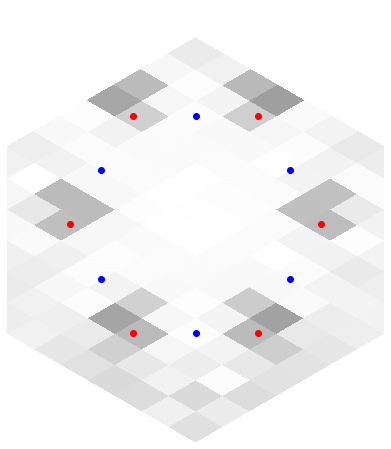

In [123]:
# Tile FT even order

'''
    When tiling things in even numbers of copies, I don't need the fftshift function since the origin would
    already be in the center
    
'''

tileNum = 2
q = make_kmesh(Nk, -tileNum/2*(b1+b2), tileNum)
nq = np.tile(np.fft.fft2(nr), (tileNum, tileNum))
#nq = np.tile(np.fft.fftshift(np.fft.fft2(nr)), (tileNum, Num))
Z = np.zeros((tileNum*Nk, tileNum*Nk), complex)
for i in range(3):
    # Sum FT with offset phase
    Z += nq[i] * np.exp(-1j * (q[0] * basis[i,0] + q[1] * basis[i,1]))

xmax = 2*np.pi/a
ymax = 4*np.pi/(3**0.5*a)

fig, ax = plt.subplots(figsize=(8,8))
im = ax.pcolormesh(q[0], q[1], np.abs(Z), vmin=0, cmap='binary', rasterized=True)
ax.set_aspect(1)

ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
ax.plot(K[:,0], K[:,1], 'ro')
ax.plot(M[:,0], M[:,1], 'bo')
ax.set_xlim(-xmax, xmax)
ax.set_ylim((-ymax, ymax))
#ax.plot(2*K[:,0], 2*K[:,1], 'ro')
#cb1 = fig.colorbar(im, ax=ax)
#cb1.ax.set_title('Pressure (Pa)')
plt.savefig(f"../../data/FT_debug/figures/kagome_14.174kHz_tile{tileNum}.png")
# M points are in blue and K points are in red